# Introduction

### This notebook use PointNet to perform 3D Object Classification on ModelNet40 Dataset.

# Creating dataset and dataloader

In [ ]:
import numpy as np
import torch
import random
import os
from torchvision import transforms

# Rewritten PointSampler
class MeshPointSampler:
    def __init__(self, num_points):
        assert isinstance(num_points, int)
        self.num_points = num_points

    @staticmethod
    def compute_triangle_area(a, b, c):
        edge1 = np.linalg.norm(a - b)
        edge2 = np.linalg.norm(b - c)
        edge3 = np.linalg.norm(c - a)
        semi_perimeter = (edge1 + edge2 + edge3) / 2
        area_sq = semi_perimeter * (semi_perimeter - edge1) * (semi_perimeter - edge2) * (semi_perimeter - edge3)
        return np.sqrt(max(area_sq, 0))

    @staticmethod
    def generate_point(a, b, c):
        r1, r2 = sorted([random.random(), random.random()])
        return r1 * a + (r2 - r1) * b + (1 - r2) * c

    def __call__(self, mesh_data):
        vertices, triangles = np.array(mesh_data[0]), mesh_data[1]
        triangle_areas = np.array([self.compute_triangle_area(vertices[t[0]], vertices[t[1]], vertices[t[2]])
                                   for t in triangles])
        sampled_triangles = random.choices(triangles, weights=triangle_areas, k=self.num_points)
        return np.array([self.generate_point(vertices[t[0]], vertices[t[1]], vertices[t[2]])
                         for t in sampled_triangles])

# Rewritten Data Transformers
class ConvertToTensor:
    def __call__(self, points):
        assert points.ndim == 2
        return torch.tensor(points)

class PointCloudNormalizer:
    def __call__(self, points):
        assert points.ndim == 2
        points_centered = points - np.mean(points, axis=0)
        scale = np.max(np.linalg.norm(points_centered, axis=1))
        return points_centered / scale

# Transforms pipeline
def create_default_transforms():
    return transforms.Compose([
        MeshPointSampler(1024),
        PointCloudNormalizer(),
        ConvertToTensor()
    ])

# Data Preprocessing and Saving Function
def preprocess_and_save_pointclouds(source_dir, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    classes = [folder for folder in sorted(os.listdir(source_dir)) if os.path.isdir(os.path.join(source_dir, folder))]
    total_processed = 0

    for category in classes:
        for split in ['train', 'test']:
            split_path = os.path.join(source_dir, category, split)
            file_names = [f for f in os.listdir(split_path) if f.endswith('.off')]
            for fname in file_names:
                path = os.path.join(split_path, fname)
                verts, faces = read_off(path)
                processed_pc = MeshPointSampler(1024)((verts, faces))
                processed_pc = PointCloudNormalizer()(processed_pc)
                torch.save(processed_pc, os.path.join(save_dir, fname.replace('.off', '.pt')))
                total_processed += 1

        print(f"Processed and saved {total_processed} point clouds so far.")

# Usage Example
data_source = '/kaggle/input/modelnet40-princeton-3d-object-dataset/ModelNet40'
save_location = '/kaggle/working'

In [6]:
save_point_clouds()

726 number of point clouds have been saved!
882 number of point clouds have been saved!
1497 number of point clouds have been saved!
1690 number of point clouds have been saved!
2362 number of point clouds have been saved!
2797 number of point clouds have been saved!
2881 number of point clouds have been saved!
3178 number of point clouds have been saved!
4167 number of point clouds have been saved!
4354 number of point clouds have been saved!
4453 number of point clouds have been saved!
4611 number of point clouds have been saved!
4897 number of point clouds have been saved!
5026 number of point clouds have been saved!
5312 number of point clouds have been saved!
5481 number of point clouds have been saved!
5752 number of point clouds have been saved!
6007 number of point clouds have been saved!
6172 number of point clouds have been saved!
6316 number of point clouds have been saved!
6485 number of point clouds have been saved!
6869 number of point clouds have been saved!
7434 number 

In [ ]:
class CustomPointCloudDataset(Dataset):
    def __init__(self, base_dir, use_test_set=False, transform_func=None):
        """
        初始化自定义点云数据集

        参数:
            base_dir: 数据根目录
            use_test_set: 是否加载测试集（默认加载训练集）
            transform_func: 数据转换函数，若未提供则使用 default_transforms()
        """
        self.base_dir = base_dir
        self.transform_func = transform_func if transform_func is not None else default_transforms()

        # 获取根目录下所有类别文件夹，并为每个类别分配唯一索引
        category_list = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
        self.category_to_index = {category: idx for idx, category in enumerate(category_list)}

        self.sample_files = []
        self.sample_labels = []
        # 根据是否加载测试集选择子文件夹
        subset_folder = 'test' if use_test_set else 'train'

        # 遍历每个类别目录，收集.off文件对应的.pt数据文件
        for category, label in self.category_to_index.items():
            folder_path = os.path.join(base_dir, category, subset_folder)
            if os.path.exists(folder_path):
                for fname in os.listdir(folder_path):
                    if fname.endswith('.off'):
                        # 去除文件扩展名后构造.pt文件名
                        base_name = fname[:-4]
                        full_path = os.path.join(folder_path, f"{base_name}.pt")
                        self.sample_files.append(full_path)
                        self.sample_labels.append(label)

    def __len__(self):
        return len(self.sample_files)

    def process_off_file(self, off_file):
        """
        读取.off文件，并利用转换函数对数据进行预处理
        """
        vertices, faces = read_off(off_file)
        processed_cloud = self.transform_func((vertices, faces))
        return processed_cloud

    def __getitem__(self, index):
        file_path = self.sample_files[index]
        label = self.sample_labels[index]
        # 加载预处理后的点云数据
        point_cloud = torch.load(file_path)
        return {'pointcloud': point_cloud, 'category': label}


# 实例化数据集及数据加载器
train_dataset = CustomPointCloudDataset(data_path)
val_dataset = CustomPointCloudDataset(data_path, use_test_set=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=4, pin_memory=True)

# Model Definition

In [8]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1).to(device)

        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 40):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

# Model Instantiation

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

pointnet = PointNet()
pointnet.to(device);
print(next(pointnet.parameters()).is_cuda)  # Should output True

optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.0008)

cuda
True


In [10]:
print(torch.cuda.is_available())  # Should print True if GPU is available
print(torch.cuda.current_device())  # Should print the index of the current GPU
print(torch.cuda.get_device_name(0))  # Should print the name of the GPU

True
0
Tesla P100-PCIE-16GB


# Training Phase

In [11]:
from tqdm import tqdm

def train(model, train_loader, val_loader=None, epochs=100):
    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for i, data in train_loader_tqdm:           
            inputs, labels = data['pointcloud'].to(device, non_blocking=True).float(), data['category'].to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 20 == 0:
                avg_loss = running_loss / 20
                train_loader_tqdm.set_postfix(loss=f"{avg_loss:.3f}")
                running_loss = 0.0

        model.eval()
        correct = total = 0

        if val_loader:
            with torch.no_grad():
                val_loader_tqdm = tqdm(val_loader, desc="Validation")
                for data in val_loader_tqdm:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, _, _ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_acc = 100. * correct / total
            print(f'Validation accuracy: {val_acc:.2f}%')

    torch.save(model.state_dict(), "0-pointNet-modelNet40.pth")

In [12]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train(pointnet, train_loader, valid_loader)

Validation: 100%|██████████| 39/39 [00:01<00:00, 21.33it/s]

Validation accuracy: 56.36%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.95it/s]

Validation accuracy: 58.95%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.89it/s]

Validation accuracy: 66.33%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.47it/s]

Validation accuracy: 69.89%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.84it/s]

Validation accuracy: 74.19%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.98it/s]

Validation accuracy: 75.97%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.00it/s]

Validation accuracy: 78.53%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.95it/s]

Validation accuracy: 81.08%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.55it/s]

Validation accuracy: 79.09%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.76it/s]

Validation accuracy: 82.05%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.87it/s]

Validation accuracy: 80.35%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.76it/s]

Validation accuracy: 81.69%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.65it/s]

Validation accuracy: 81.93%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.86it/s]

Validation accuracy: 81.56%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.93it/s]

Validation accuracy: 82.25%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.65it/s]

Validation accuracy: 81.28%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.75it/s]

Validation accuracy: 80.71%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.59it/s]

Validation accuracy: 81.48%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.90it/s]

Validation accuracy: 83.43%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.48it/s]

Validation accuracy: 83.91%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.08it/s]

Validation accuracy: 81.89%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.93it/s]

Validation accuracy: 82.46%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.17it/s]

Validation accuracy: 81.20%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.14it/s]

Validation accuracy: 84.16%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.13it/s]

Validation accuracy: 80.79%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.07it/s]

Validation accuracy: 85.29%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.92it/s]

Validation accuracy: 86.35%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.16it/s]

Validation accuracy: 84.72%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.76it/s]

Validation accuracy: 83.02%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.82it/s]

Validation accuracy: 85.74%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.09it/s]

Validation accuracy: 84.76%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.90it/s]

Validation accuracy: 84.60%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.27it/s]

Validation accuracy: 83.23%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.19it/s]

Validation accuracy: 86.43%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.73it/s]

Validation accuracy: 84.40%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.00it/s]

Validation accuracy: 82.74%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.03it/s]

Validation accuracy: 81.20%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.16it/s]

Validation accuracy: 84.81%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.98it/s]

Validation accuracy: 86.55%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.16it/s]

Validation accuracy: 86.10%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.10it/s]

Validation accuracy: 85.29%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.11it/s]

Validation accuracy: 84.85%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.11it/s]

Validation accuracy: 83.59%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.14it/s]

Validation accuracy: 82.46%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.20it/s]

Validation accuracy: 83.91%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.93it/s]

Validation accuracy: 85.13%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.27it/s]

Validation accuracy: 83.10%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.08it/s]

Validation accuracy: 88.61%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.02it/s]

Validation accuracy: 86.99%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.17it/s]

Validation accuracy: 86.67%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.96it/s]

Validation accuracy: 83.67%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.14it/s]

Validation accuracy: 84.93%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.96it/s]

Validation accuracy: 86.87%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.05it/s]

Validation accuracy: 85.78%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.96it/s]

Validation accuracy: 86.47%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.96it/s]

Validation accuracy: 87.76%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.89it/s]

Validation accuracy: 86.26%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.06it/s]

Validation accuracy: 86.06%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.73it/s]

Validation accuracy: 87.40%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.10it/s]

Validation accuracy: 85.62%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.10it/s]

Validation accuracy: 85.74%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.03it/s]

Validation accuracy: 86.59%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.98it/s]

Validation accuracy: 85.94%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.16it/s]

Validation accuracy: 85.58%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.05it/s]

Validation accuracy: 86.26%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.01it/s]

Validation accuracy: 85.62%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.98it/s]

Validation accuracy: 84.81%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.02it/s]

Validation accuracy: 85.66%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.12it/s]

Validation accuracy: 85.98%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.65it/s]

Validation accuracy: 87.44%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.08it/s]

Validation accuracy: 86.63%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.72it/s]

Validation accuracy: 87.12%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.18it/s]

Validation accuracy: 84.72%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.01it/s]

Validation accuracy: 86.47%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.17it/s]

Validation accuracy: 88.13%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.56it/s]

Validation accuracy: 86.26%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.61it/s]

Validation accuracy: 85.78%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.87it/s]

Validation accuracy: 85.29%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.04it/s]

Validation accuracy: 86.63%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.84it/s]

Validation accuracy: 87.36%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.11it/s]

Validation accuracy: 85.33%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.75it/s]

Validation accuracy: 86.63%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.62it/s]

Validation accuracy: 87.72%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.84it/s]

Validation accuracy: 88.01%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.65it/s]

Validation accuracy: 85.94%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.96it/s]

Validation accuracy: 84.44%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.00it/s]

Validation accuracy: 86.18%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.98it/s]

Validation accuracy: 86.35%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.76it/s]

Validation accuracy: 85.90%



Validation: 100%|██████████| 39/39 [00:01<00:00, 22.07it/s]

Validation accuracy: 87.36%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.86it/s]

Validation accuracy: 86.10%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.53it/s]

Validation accuracy: 87.07%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.90it/s]

Validation accuracy: 85.82%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.53it/s]

Validation accuracy: 87.48%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.72it/s]

Validation accuracy: 86.99%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.70it/s]

Validation accuracy: 85.90%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.84it/s]

Validation accuracy: 87.52%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.96it/s]

Validation accuracy: 86.75%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.79it/s]

Validation accuracy: 87.32%



Validation: 100%|██████████| 39/39 [00:01<00:00, 21.41it/s]

Validation accuracy: 87.24%


# Evaluation Phase

In [13]:
all_preds = []
all_labels = []

def validate(pointnet, valid_loader, all_preds, all_labels):
    pointnet.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
            
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)  # Move to GPU
            outputs, __, __ = pointnet(inputs.transpose(1,2))
            _, preds = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            all_preds += list(preds.cpu().numpy())  # Move predictions back to CPU for numpy
            all_labels += list(labels.cpu().numpy())  # Same for labels
    print(f"Test Accuracy: {100 * correct/total:.2f}%")

In [14]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    validate(pointnet, valid_loader, all_preds, all_labels)

Batch [   1 /   39]
Batch [   2 /   39]
Batch [   3 /   39]
Batch [   4 /   39]
Batch [   5 /   39]
Batch [   6 /   39]
Batch [   7 /   39]
Batch [   8 /   39]
Batch [   9 /   39]
Batch [  10 /   39]
Batch [  11 /   39]
Batch [  12 /   39]
Batch [  13 /   39]
Batch [  14 /   39]
Batch [  15 /   39]
Batch [  16 /   39]
Batch [  17 /   39]
Batch [  18 /   39]
Batch [  19 /   39]
Batch [  20 /   39]
Batch [  21 /   39]
Batch [  22 /   39]
Batch [  23 /   39]
Batch [  24 /   39]
Batch [  25 /   39]
Batch [  26 /   39]
Batch [  27 /   39]
Batch [  28 /   39]
Batch [  29 /   39]
Batch [  30 /   39]
Batch [  31 /   39]
Batch [  32 /   39]
Batch [  33 /   39]
Batch [  34 /   39]
Batch [  35 /   39]
Batch [  36 /   39]
Batch [  37 /   39]
Batch [  38 /   39]
Batch [  39 /   39]
Test Accuracy: 87.24%


In [15]:
cm = confusion_matrix(all_labels, all_preds)

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


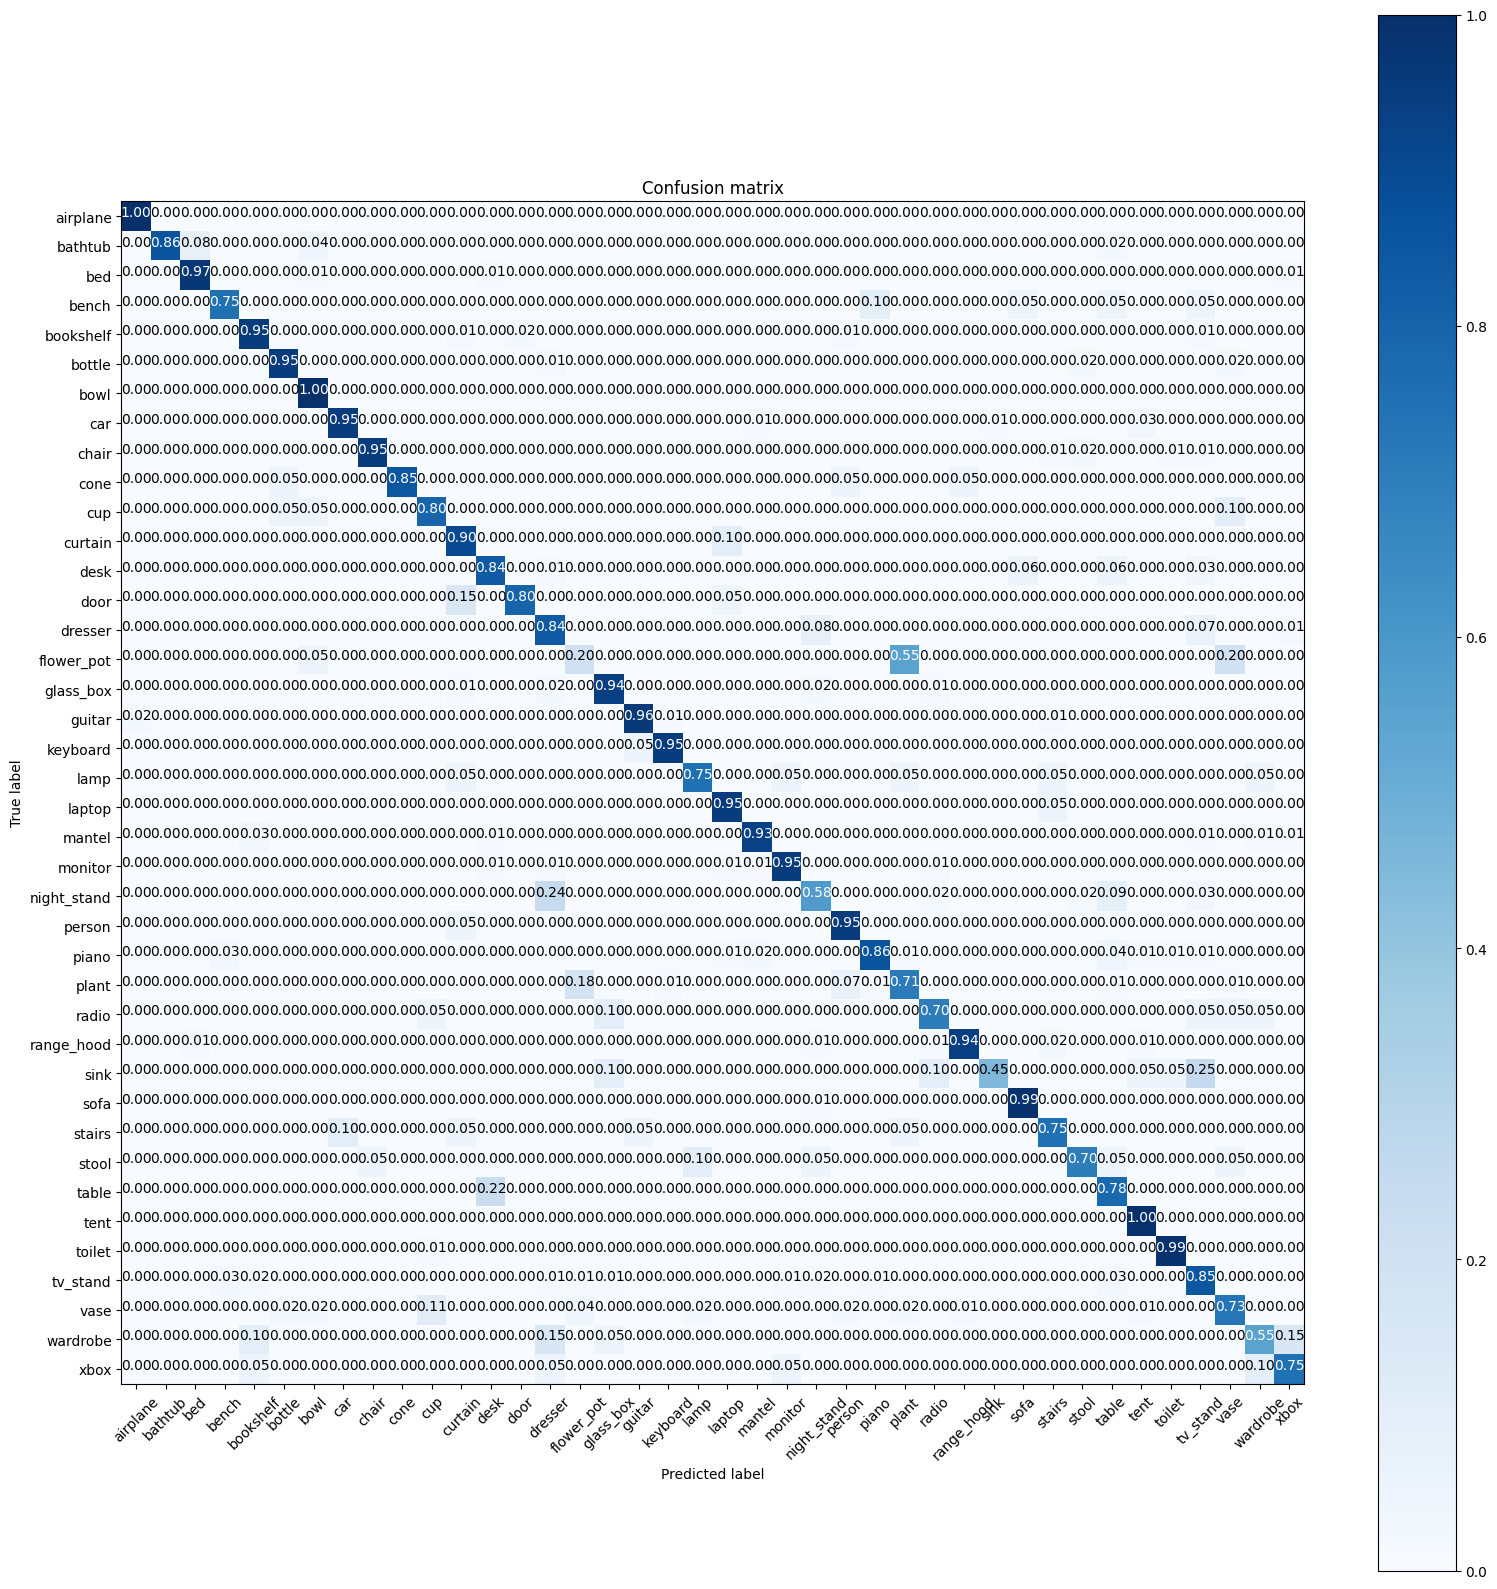

In [17]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(cm, folders, normalize=True)

Confusion matrix, without normalization


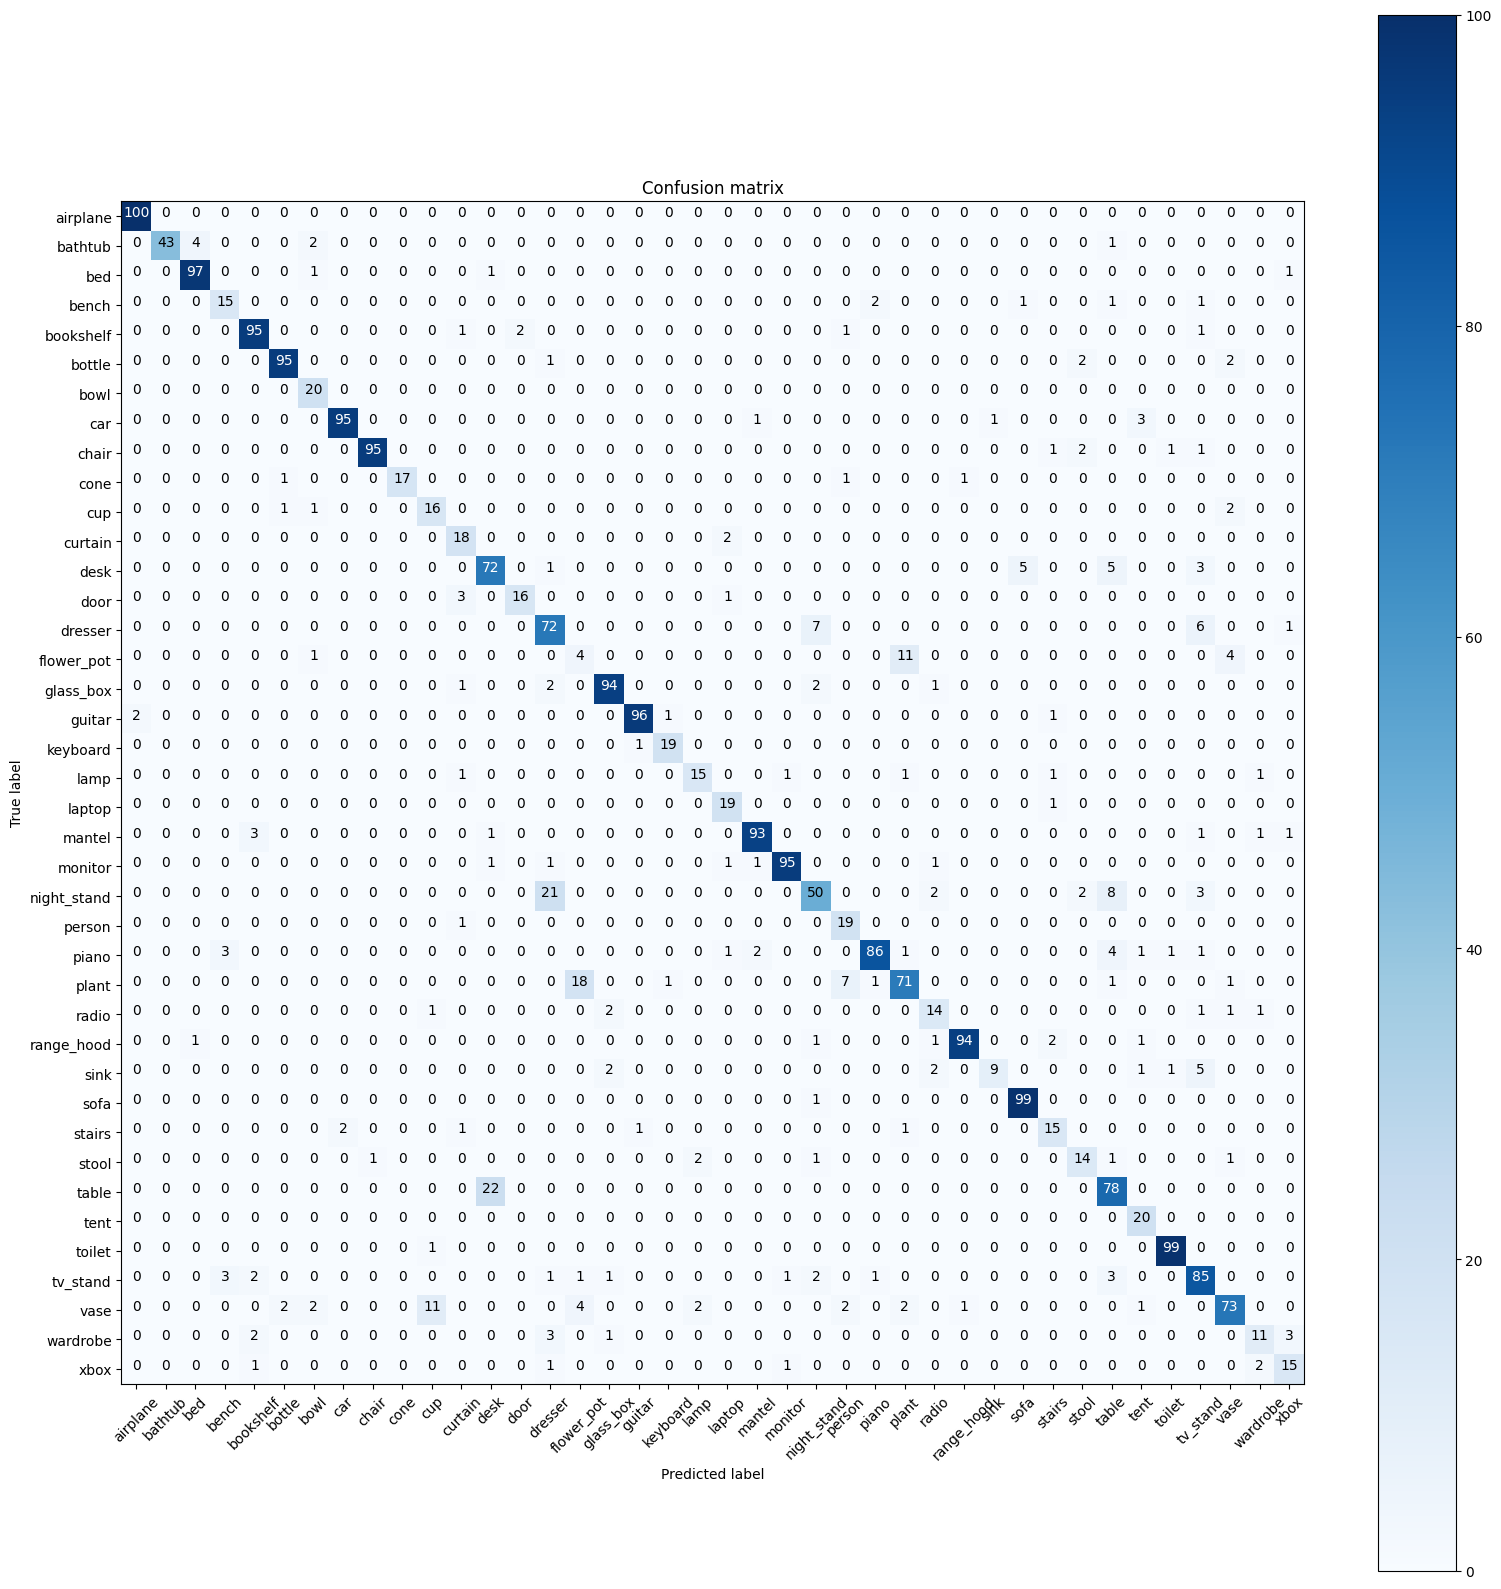

In [18]:
plt.figure(figsize=(16,16))
plot_confusion_matrix(cm, folders, normalize=False)